# AtLAST Debris Disc Case

Example script for determining detection limits of debris discs using continuum observations with AtLAST. In order to use this you will first need to install the sensitivity calculator: https://github.com/ukatc/AtLAST_sensitivity_calculator.

In [5]:
import numpy as np
import matplotlib.pyplot as pl

In [6]:
# Set-up sensitivity calculator
from atlast_sc.calculator import Calculator
import astropy.units as u
import astropy.constants as const
calculator = Calculator()

First lets take a look at the default inputs for the calculator.

In [7]:
print(calculator.user_input)

t_int: 100.0 s
sensitivity: 3.0 mJy
bandwidth: 100.0 MHz
obs_freq: 100.0 GHz
n_pol: 2.0 GHz
weather: 25.0 GHz
elevation: 45.0 deg


You can either define the integration time and calculate the sensitivity or vice versa. Let's start by seeing how deep we can go with a 1 hour observation. We want to do a continuum survey, so lets increase the bandwidth to 32 GHz.

In [16]:
calculator.t_int = 1*u.h
calculator.bandwidth = 32*u.GHz

For debris disc SEDs we need to define the Planck function and a grey-body approximation factor to take into account the steeper slope at long wavelengths.

In [9]:
def bnu(wav, temp):
    # Planck function for wavelength in microns and temperature in K
    # Give the constants for this function, where:
    # h = 6.6260755*10^{-34} Js is Planck's constant,
    # k = 1.380658*10^{-23} J/K is Boltzmann's constant,
    # c = 2.997924580*10^8 m/s is the speed of light.
    k1 = 3.9728949e19 # = 2hc in Jy*mum^3, i.e., = (2hc)*1e(18+26)
    k2 = 14387.69     # = hc/k in mum*K, i.e., = (hc/k)*1e6
    wav = float(wav)
    fact1 = k1/wav**3
    fact2 = k2/(wav*temp)
    return fact1/(np.exp(fact2) - 1.0)

def xlam(wav, wav0=160,beta=0.7):
    # Grey-body approximation. The default values for wav0 and beta are based on the SONS survey (Holland et al. 2017)
    wav=np.array(wav)
    xlamr=np.ones_like(wav,dtype=float)
    xlamr[wav > wav0] = (wav[wav > wav0]/float(wav0))**beta
    return xlamr

Let's assume a Sun-like star at 10pc.

In [10]:
dist = 10
lstar = 1.

Now we set up our array of radii, convert to temperatures, select the range of frequencies we want to test, calculate the sensitivity reached for these, estimate the beam dilution factor due to resolving the disc*, convert to a fractional luminosity and plot the results.
\* This is crudely done here by assuming no. of beams = disc area / beam area for a marginally resolved system and no. of beams = disc circumference / fwhm for a clearly resolved system. The minimum no. of beams is taken with a lower limit of 1.

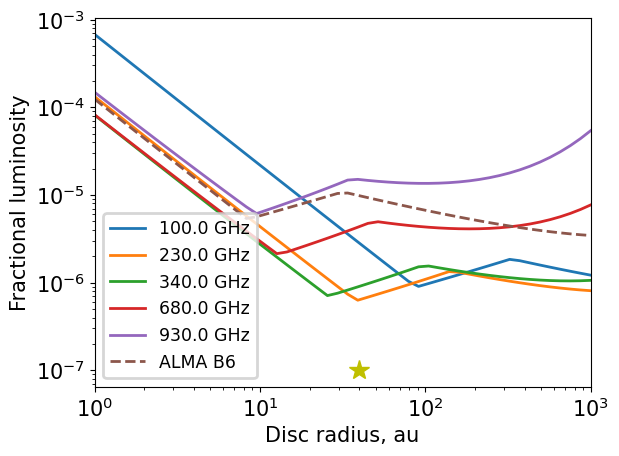

In [18]:
radius = np.logspace(0,3)
temp = 278.3*lstar**0.25/radius**0.5
freqs=[100,230, 340,680,930]*u.GHz  # The permitted range of values is 35-950 GHz
assumepoint=False   # assume a point source or calculate beam dilution factor
sensarr=[]
pl.figure()
for f in freqs:
    calculator.obs_freq = f
    sens=calculator.calculate_sensitivity()
    sensarr.append(sens)
    wav=(const.c/f).to(u.um).value
    if assumepoint:
        beamdilutefact=1
    else:
        # Resolution of a telescope in radians given by 0.2*lambda/D
        # If lambda in µm, D in m and we want the resolution in arcsec then 0.244*lambda/D
        fwhm=0.244*wav/(2*calculator.dish_radius.value)
        beamarea=np.pi*fwhm**2/(4*np.log(2))
        # If the disc is resolved this will spread the flux over multiple beams
        # Assume here a narrow belt and so the number of beams to cover the area when mariginally resolved or
        # the number of beams to cover the circumference when the inner edge would be resolved
        beamdilutefact=[max(1,min(np.pi*2*r/dist/fwhm,np.pi*(r/dist)**2/beamarea)) for r in radius]
    fdet = 3.4e9*3*sens.to(u.Jy).value*dist**2/radius**2/bnu(wav,temp)*xlam(wav)*beamdilutefact
    pl.loglog(radius, fdet,label=str(f))
pl.xlabel('Disc radius, au')
pl.ylabel('Fractional luminosity')
# Add Kuiper belt - based on Vitense et al. (2012)
pl.plot(40,1e-7,'y*',markersize=15)

# Here's ALMA B6 for comparison
senslim=12.5e-6
wav=1300
label='ALMA B6'
fwhm=1.4
beamarea=np.pi*fwhm**2/(4*np.log(2))
if assumepoint:
    beamdilutefact=1
else:
    beamdilutefact=[max(1,min(np.pi*2*r/dist/fwhm,np.pi*(r/dist)**2/beamarea)) for r in radius]
fdet = 3.4e9*3*senslim*dist**2/radius**2/bnu(wav,temp)*xlam(wav)*beamdilutefact
pl.loglog(radius, fdet,ls='--',label=label)
pl.legend(prop={'size':'small'},numpoints=1)


We're not quite reaching Kuiper belt levels of fractional luminosity here, but we can also consider the opposite question of how much time would we need to reach that level.

In [13]:
# Sensitivity required to reach 3sig detection of Kuiper belt at 10pc
fkb = 1e-7
rkb = 40.
dist = 10
lstar = 1.
tkb = 278.3*lstar**0.25/rkb**0.5
assumepoint=False
freqs=[100,230, 340,680,930]*u.GHz
tarr=[]
for f in freqs:
    print('Frequency',f)
    calculator.obs_freq = f
    wav=(const.c/f).to(u.um).value
    fwhm=0.244*wav/(2*calculator.dish_radius.value)
    beamarea=np.pi*fwhm**2/(4*np.log(2))
    if assumepoint:
        beamdilutefact=1
    else:
        beamdilutefact=max(1,min(np.pi*2*rkb/dist/fwhm,np.pi*(rkb/dist)**2/beamarea))
    skb = fkb/(3.4e9*3*dist**2*xlam(wav)*beamdilutefact)*rkb**2*bnu(wav,tkb)
    print('Sensitivity required: ',skb*u.Jy)
    t=calculator.calculate_t_integration(sensitivity=skb*u.Jy)
    print('Time required: ',t)
    tarr.append(t)


Frequency 100.0 GHz
Sensitivity required:  2.580409461610563e-07 Jy
Time required:  793.5851783691136 h
Frequency 230.0 GHz
Sensitivity required:  2.0733023121918873e-06 Jy
Time required:  40.849830086394284 h
Frequency 340.0 GHz
Sensitivity required:  2.559112754427623e-06 Jy
Time required:  82.45839213193278 h
Frequency 680.0 GHz
Sensitivity required:  3.3951954174020534e-06 Jy
Time required:  1903.6177753615405 h
Frequency 930.0 GHz
Sensitivity required:  4.057834999757793e-06 Jy
Time required:  22507.38672010383 h
